LAS file Processing Tools

# Tools for Deriving Products from LAS files
## Introduction
This jupyter notebook is designed to enable the efficient processing of LAS files. LAS files are an industry standard binary format for storing aerial LiDAR data. The python script in this notebook completes a number of processes useful for analysis. 
**Note:  As this script uses the arcpy package, it can only be run on a  machine with Arcgis Pro installed although ArcGIS Pro doesn't need to be running.**
## Workflow
The following processes are carried out in this script.
1. A Las dataset is created from the LAS files. A LAS dataset is a file storage container for LAS files used by ESRI
2. The ground surface is extracted and classified. This is the process where all the points in the cloud are processed and those deemed to form the bare earth surface are given a classification of "2" which is the designation for ground points in the LAS specification.
3. A digital Surface Model (DSM) of the pointcloud is generated. This is a raster file with the pixels representing the elevation of the non classified cloud.
4. A Digital Terrain Model is created of the ground. This is a raster file with the pixels representing the elevation of the points designated as bare earth.
5. A difference raster is created by subtracting the DTM from the DSM to show the vegetation height in the area of interest
6. If a shapefile is included containing a line feature class representing cross sections then these will be extracted and plotted in the notebook as well as being exported as a jpeg and a CSV file.

** A sample dataset containing a LAS file and a shapefile can be downloaded [here](https://drive.google.com/drive/folders/1oWOcZGH8XyItQWyAD-vEmMEGzo5CKYn_?usp=sharing)



## Cell 1: Impoting the required modules. 
Click in the cell below a click run to import the necessary python modules. When it is finished you will see a message saying "Completed".

In [1]:
import arcpy
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import rasterio
print('Completed')

Completed


## Cell 2: Inputting the variables
The cell below requires the user to input the paths and names for various inputs and outputs. If the user is mirroring the same folder naming convention and structure as the default, then no changes are needed. (See the user manual for a full description of the default folder structure). If the user has a different folder structure, then the paths in the variables below need to be altered accordingly.

**Note that all but one of the path variables below reference a folder location. For this reason, they are referenced with a double backslash. The user will need to replicate this if copying and pasting a path to their own folder location. The variable "pointcloud_path" references the Pointcloud.las file and not the folder containing it so the path to the users own LAS file can be pasted within the quotes. For this reason, the LAS file can have any name.

##### arcpy_env_workspace
This variable creates a temporary file geodatabase called temp.gdb for storing layers etc while the tool is running. It can be deleted when the session is finished.

##### pointcloud_path
This is the path to the pointcloud LAS file.

##### raster_folder
This is the path where the raster output (DTM and DSMs) will be stored

##### ground_DSM 
This is the name of the raster representing the ground surface. The user can use whatever name they choose but the file extension should be .tif format

##### surface_model
This is the name to be given to the raster representing the DSM. Again the user can choose their own name.

##### cross_sections
This is the path to the shapefile containing the cross-sections. See the "Getting Started" section of theuser manual for the required attributes of the shapefile.

The other two variables (**ground_raster_full_path** and **surface_raster_full_path**) are used internally within the code and should not be set by the user.

In [2]:
arcpy_env_workspace = "C:\\DSM_Tools\\"  # enter path and name of workspace here
pointcloud_path = r"C:\DSM_Tools\LAS_Processing_Tools\Pointcloud_Data\Pointcloud.las" #enter the path to your LAS files
las_dataset_path = "C:\\DSM_Tools\\LAS_Processing_Tools\\Pointcloud_Data\\"# enter las dataset path here
raster_folder = "C:\\DSM_Tools\\LAS_Processing_Tools\\rasters\\"  #enter path to where output rasters ar to be stored
ground_dsm = "ground_DSM.tif"
surface_model = "surface_DSM.tif"
cross_sections = gpd.read_file(r'C:\DSM_Tools\LAS_Processing_Tools\xsections\xsections.shp') # enter path to your cross-sections shapefile here
ground_raster_full_path = os.path.join(raster_folder, ground_dsm)
surface_model_full_path = os.path.join(raster_folder, surface_model)
print('Completed')

Completed


## Cell 3
This cell creates the temporary file geodatabase in the folder specified in the previous cell. If there is a geodatabase of the same name already there, it will be deleted.This cell needs no input from the user and can be run as it is.

In [3]:
#create a temporary geodatabase in workspace
if arcpy.Exists(arcpy_env_workspace +"temp.gdb"):
    arcpy.Delete_management(arcpy_env_workspace +"temp.gdb")
arcpy.management.CreateFileGDB(arcpy_env_workspace, 'temp')

<Result 'C:\\DSM_Tools\\temp.gdb'>

## Cell 4
This cell uses arcpy to create a las dataset which is a pointer to a set of related las files. The parameters that need to be set here are...

Input: "NO_RECURSION" - only las files in the input folder are added to the dataset or "RECURSION" - las files in subdirectories will be added to the dataset.

Surface Constraints: Any polygons or other feature classes to be referenced by the LAS dataset. The default is "None". See arcgis pro help for more info if feature types are to be included.

Coordinate reference system: This is the EPSG code of the CRS for the LAS files. If this is not set then the CRS will be unknown. The default used here is "27700" which is the British National Grid.

Compute Stats: This is optional and can be set to "COMPUTE_STATS" or "NO_COMPUTE_STATS"(default). 





In [4]:
#First make las dataset from pointcloud
if arcpy.Exists(las_dataset_path+"Pointcloud.lasd"):
    arcpy.Delete_management(las_dataset_path+"Pointcloud.lasd")



arcpy.management.CreateLasDataset(pointcloud_path,
                                  las_dataset_path+"Pointcloud.lasd", 
                                  "NO_RECURSION", 
                                  None,
                                  arcpy.SpatialReference(27700), 
                                  "COMPUTE_STATS")

<Result 'C:\\DSM_Tools\\LAS_Processing_Tools\\Pointcloud_Data\\Pointcloud.lasd'>

## Cell 5
The code here classifies those points considered to be ground. If the pointcloud has already been classified and has ground points designated in it, then there is no need run the code in this cell. If the cloud hasn't been classified then all the points will have a code of "1" (unassigned) or  "0" (never classified) 
The parameters for the user to set here are here are...

method: "STANDARD", "CONSRVATIVE" or "AGGRESSIVE". This determines the tollerance for slope variation. "CONSERVATIVE" is more likely to filter out sharp changes in slope  that may caused by low lying vegetation such as shrubs where as "AGGRESSIVE" detects surfaces with sharper relief. Standard is between the two.

Reuse_ground: "RECLASSIFY_GROUND" reclassiifes points that have already been classed as ground whereas "REUSE_GROUND" accepts point that have already been clasified as ground.

compute_stats: see explanation for Cell 4

There are other parameters that can be set for this tool such as adding a boundary polygon. The user can review the "classify las ground tool" for more information.

https://desktop.arcgis.com/en/arcmap/10.5/tools/3d-analyst-toolbox/classify-las-ground.htm





In [5]:
##Classify the ground surface

arcpy.ddd.ClassifyLasGround(las_dataset_path+"Pointcloud.lasd", 
                            "AGGRESSIVE", 
                            "RECLASSIFY_GROUND", 
                            None, 
                            "COMPUTE_STATS")


<Result 'C:\\DSM_Tools\\LAS_Processing_Tools\\Pointcloud_Data\\Pointcloud.lasd'>

In [6]:
 
if arcpy.Exists("Pointcloud_LasDatasetLayer"):
    arcpy.Delete_management("Pointcloud_LasDatasetLayer")
    

arcpy.management.MakeLasDatasetLayer(las_dataset_path+"Pointcloud.lasd", "Pointcloud_LasDatasetLayer", "2", None, "INCLUDE_UNFLAGGED", "INCLUDE_SYNTHETIC", "INCLUDE_KEYPOINT", "EXCLUDE_WITHHELD", None, "INCLUDE_OVERLAP")

<Result 'Pointcloud_LasDatasetLayer'>

In [7]:
if arcpy.Exists(ground_raster_full_path):
    arcpy.Delete_management(ground_raster_full_path)
arcpy.conversion.LasDatasetToRaster("Pointcloud_LasDatasetLayer", ground_raster_full_path, 
                                    "ELEVATION", "BINNING AVERAGE LINEAR", "FLOAT", "CELLSIZE", 0.1, 1)


<Result 'C:\\DSM_Tools\\LAS_Processing_Tools\\rasters\\ground_DSM.tif'>

In [8]:
if arcpy.Exists(surface_model_full_path):
    arcpy.Delete_management(surface_model_full_path)
                
                
arcpy.conversion.LasDatasetToRaster(las_dataset_path+"Pointcloud.lasd", surface_model_full_path, 
                                    "ELEVATION", "BINNING AVERAGE LINEAR", "FLOAT", "CELLSIZE", 0.1, 1)

<Result 'C:\\DSM_Tools\\LAS_Processing_Tools\\rasters\\surface_DSM.tif'>

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


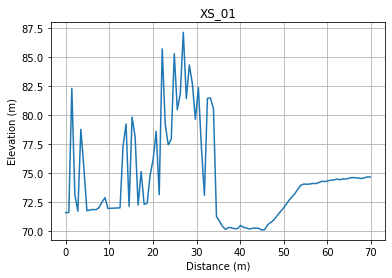

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


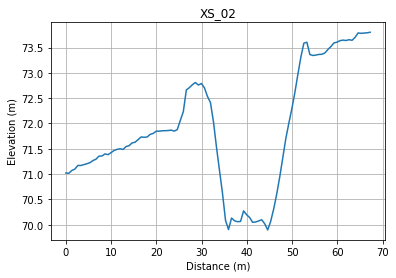

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


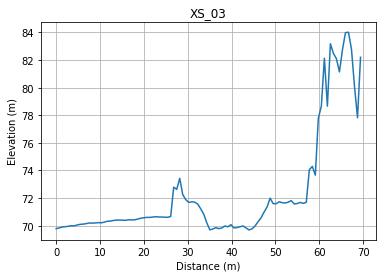

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


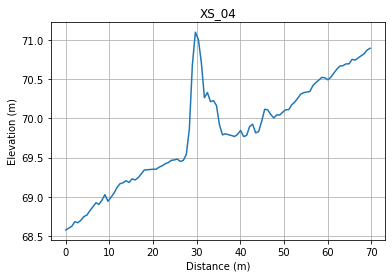

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


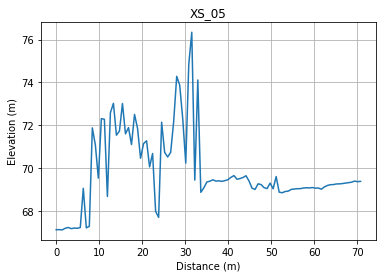

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


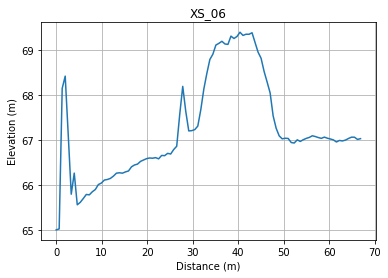

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


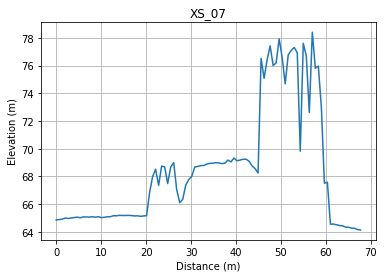

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


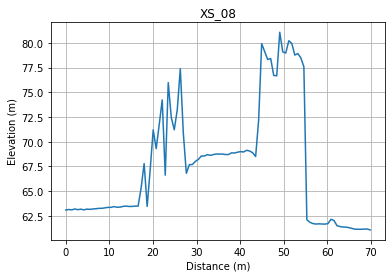

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


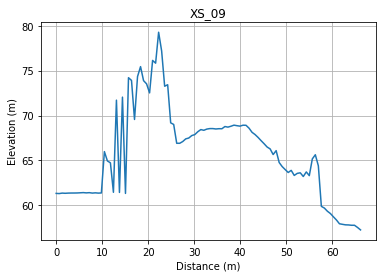

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


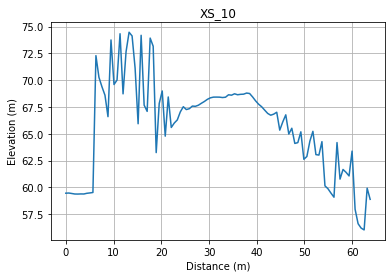

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


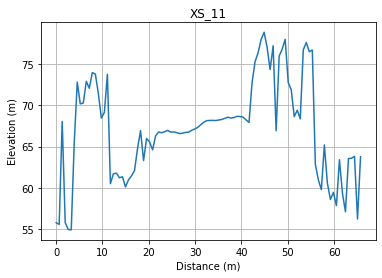

C:\Users\Paul\anaconda3\envs\LAS_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


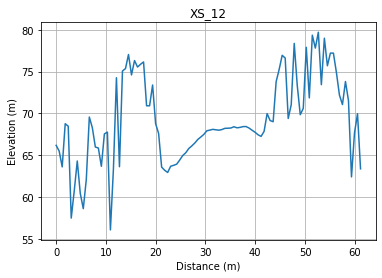

Script Completed


In [11]:
for index, row in cross_sections.iterrows():
     XS_id = row['xs_id'] # input shapefile id colunm name here

 ##This section of code shows how to create a x-section from a shapefile
     start_coords = list([row.geometry][0].coords)[0]
     end_coords = list([row.geometry][0].coords)[1]
     eastings = [start_coords[0]] #eastings of start point
     northings = [start_coords[1]] #northings of start point written as a list so it has an append attribute
     no_pts = 100 # this is the number of points the dsm will be sampled at between the two end points of each x-section


     # np.arange subdivides a line equally between two points.
     for i in np.arange(1, no_pts+1):  # we have no_points + 1 as np.arrange doesnt include the last point
         x_dist = end_coords[0]-start_coords[0]  #difference between eastings
         y_dist = end_coords[1]-start_coords[1]  # difference between northings
         point = [(start_coords[0] + (x_dist/(no_pts+1))*i), (start_coords[1] + (y_dist/(no_pts+1))*i)]
         eastings.append(point[0])
         northings.append(point[1])

     eastings.append(end_coords[0])
     northings.append(end_coords[1]) #the end coordinates are now appended to the coordinate list

     # Make points from x-section list and into a pandas dataframe
     dfr = pd.DataFrame({'Eastings': eastings,
                           'Northings': northings})

     #make a geodataframe from pandas df
     gdfr = gpd.GeoDataFrame(dfr, geometry = gpd.points_from_xy(dfr['Eastings'], dfr['Northings']), crs= 'EPSG:27700')

     #add a horizontal distance from beginning of line for x-section plot
     gdfr['hz_dist'] = 0

     for index, row in gdfr.iterrows():
         gdfr['hz_dist'].loc[index]  = gdfr.geometry[0].distance(gdfr.geometry[index])



     #Extracting elevations from DEM
     # First create 'Elevation' column in gdfr and assign initial value of 0
     gdfr['Elevation'] =0


     ##dsm = rasterio.open(r'C:\Tool\DSM_Processing\Pointcloud_Data\Pointcloud.tif', mode = 'r') # enter path to raster here
     dsm = rasterio.open(surface_model_full_path, mode='r')  # enter path to raster here

     for index, row in gdfr.iterrows():  # this looks through each row on the index column and extracts the N & E
         row, col = dsm.index(row['Eastings'], row['Northings'])
         dsm_data =dsm.read(1)

         gdfr['Elevation'].loc[index] = dsm_data[row, col]  # this creates a column called Elevation in the x-section and assigns the raster elevation to it.

  # Extract hz_dist (x) and Elevation (y) into Pandas df
     x_y_data = gdfr[['hz_dist', 'Elevation']]
     x_y_data.to_csv(r'C:\DSM_Tools\LAS_Processing_Tools\Extracted_sections' + '\\' + XS_id + '.csv')

     # Create plots using matplotlib for each x-section
     plt.plot(gdfr['hz_dist'], gdfr['Elevation'])
     plt.xlabel('Distance (m)')
     plt.ylabel('Elevation (m)')
     plt.grid(True)
     plt.title(XS_id)
     plt.savefig(r'C:\DSM_Tools\LAS_Processing_Tools\Extracted_sections'+ '\\'+ XS_id + '.jpg')
     plt.show()





print ("Script Completed")